# Diffusion Models from Scratch

## Setup and Imports:

In [1]:
# %pip install -q diffusers

In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## The Data

In [3]:
# Custom dataset class for .npy
class CustomDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.npy_files = [f for f in os.listdir(dataset_dir) if f.endswith(".npy")]

    def __len__(self):
        return len(self.npy_files)

    def __getitem__(self, idx):
        npy_path = os.path.join(self.dataset_dir, self.npy_files[idx])
        image = np.load(npy_path)  # Load numpy array
        image = Image.fromarray(image.astype(np.uint8))  # Convert to PIL Image (grayscale)

        if self.transform:
            image = self.transform(image)

        return {"images": image}


In [4]:
# Custom dataset class for .png
class CustomDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(dataset_dir) if f.endswith(".png")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataset_dir, self.image_files[idx])
        image = Image.open(img_path).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return {"images": image}

In [5]:
# Define dataset directory
dataset_dir = "/home/benet/data/VH2D/images/flair"  # Change this to your folder path
image_size = 256
batch_size = 16
image_size = 64

# Define transformations
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize all images
    # transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),  # Convert to PyTorch tensor
    # transforms.Normalize([0.5], [0.5])  # Normalize grayscale images
])


# Create dataset and dataloader
dataset = CustomDataset(dataset_dir, transform=preprocess)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


torch.Size([16, 1, 64, 64])


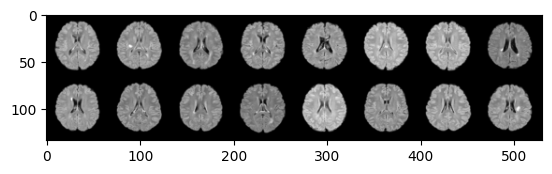

In [6]:
images = next(iter(train_dataloader))["images"]
print(images.shape)
plt.imshow(torchvision.utils.make_grid(images)[0], cmap="gray")

## The UNet

In [7]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount

In [8]:
#@markdown Trying UNet2DModel instead of BasicUNet:


# How many runs through the data should we do?
n_epochs = 50

# Create the network
net = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for batch in train_dataloader:
        x = batch["images"]  # dataset returns a dictionary with 'images' as a key

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

Finished epoch 0. Average loss for this epoch: 0.072193
Finished epoch 1. Average loss for this epoch: 0.015074
Finished epoch 2. Average loss for this epoch: 0.011436
Finished epoch 3. Average loss for this epoch: 0.008984
Finished epoch 4. Average loss for this epoch: 0.007594
Finished epoch 5. Average loss for this epoch: 0.007310
Finished epoch 6. Average loss for this epoch: 0.006788
Finished epoch 7. Average loss for this epoch: 0.006636
Finished epoch 8. Average loss for this epoch: 0.005777
Finished epoch 9. Average loss for this epoch: 0.005451
Finished epoch 10. Average loss for this epoch: 0.005641
Finished epoch 11. Average loss for this epoch: 0.005368
Finished epoch 12. Average loss for this epoch: 0.005243
Finished epoch 13. Average loss for this epoch: 0.005368
Finished epoch 14. Average loss for this epoch: 0.005291
Finished epoch 15. Average loss for this epoch: 0.004767
Finished epoch 16. Average loss for this epoch: 0.004633
Finished epoch 17. Average loss for this 

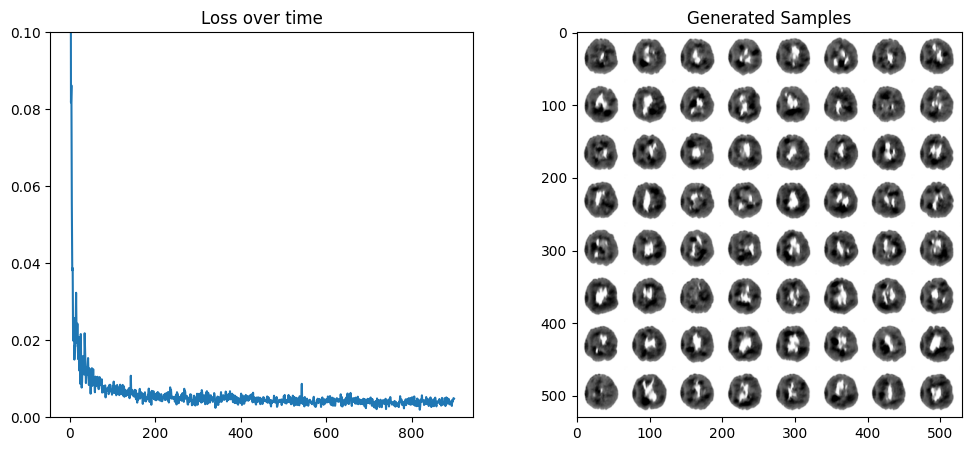

In [9]:
# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, image_size, image_size).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');